# Plots for mutation-transmissibility paper

This notebook generates plots for the paper/ directory. This assumes you've alread run
```sh
python mutrans.py  # ~2 hours on GPU (mostly MCMC)
```

In [1]:
import math
import pickle
import logging
from collections import Counter, OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin

torch.set_default_dtype(torch.double)
matplotlib.rcParams['figure.dpi'] = 200
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

## Theory

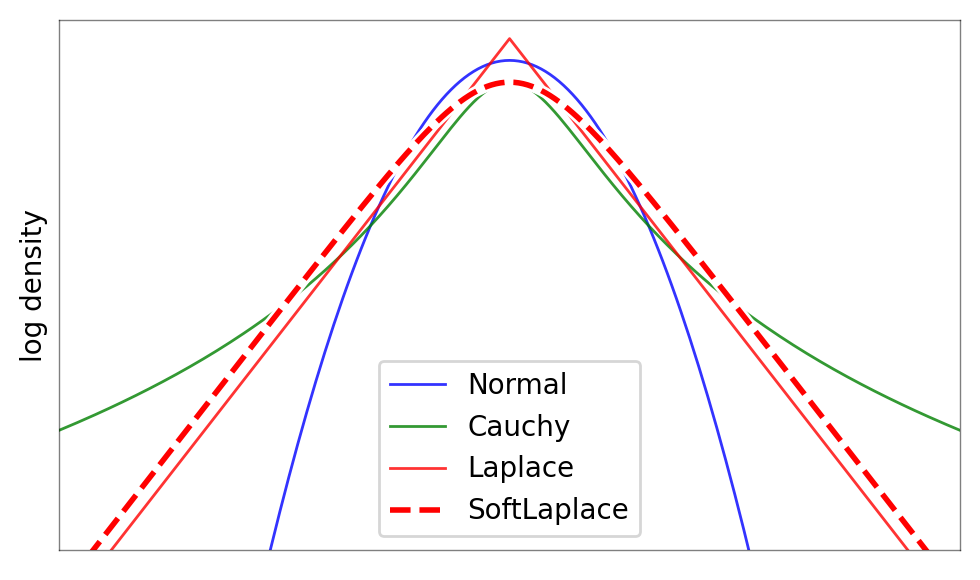

In [2]:
x = torch.linspace(-6, 6, 201)
plt.figure(figsize=(5, 3))
plt.plot(x, dist.Normal(0, 1).log_prob(x), 'b-', lw=1, label="Normal", alpha=0.8)
plt.plot(x, dist.Cauchy(0, 1).log_prob(x), 'g-', lw=1, label="Cauchy", alpha=0.8)
plt.plot(x, dist.Laplace(0, 1).log_prob(x), 'r-', lw=1, label="Laplace", alpha=0.8)
plt.plot(x, dist.SoftLaplace(0, 1).log_prob(x), 'w-', lw=4)
plt.plot(x, dist.SoftLaplace(0, 1).log_prob(x), 'r--', lw=2, label="SoftLaplace")
plt.ylabel("log density")
plt.ylim(-6, -0.5)
plt.xlim(-6, 6)
plt.xticks(())
plt.yticks(())
plt.legend(loc='lower center')
plt.tight_layout()
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)
    spine.set_alpha(0.5)

## Load data

In [28]:
%%time
dataset = mutrans.load_gisaid_data(max_feature_order=1)  # TODO remove max_feature_order=1
dataset.update(mutrans.load_jhu_data(dataset))
print(dataset.keys())
locals().update(dataset)
print(len(mutations))

   202780 Loading data
   203464 Training on 1083563 rows with columns:
   203465 lineage, virus_name, accession_id, collection_date, location, add_location, day
   203539 Loaded torch.Size([1255, 5956]) feature matrix
   214468 Keeping 1083563/1083563 rows
   214496 Keeping 287/311 regions
   215008 Loaded 441 x 3616 daily case data, totaling 22482992271.0
   215009 Joining GISAID and JHU region codes
   215297 Matching 287 GISAID regions to 3616 JHU fuzzy regions


dict_keys(['location_id', 'mutations', 'weekly_strains', 'features', 'feature_order', 'feature_order_max', 'lineage_id', 'lineage_id_inv', 'local_time', 'daily_cases', 'weekly_cases'])
5956
CPU times: user 12.3 s, sys: 709 ms, total: 13 s
Wall time: 12.6 s


Sanity checking case count time series:

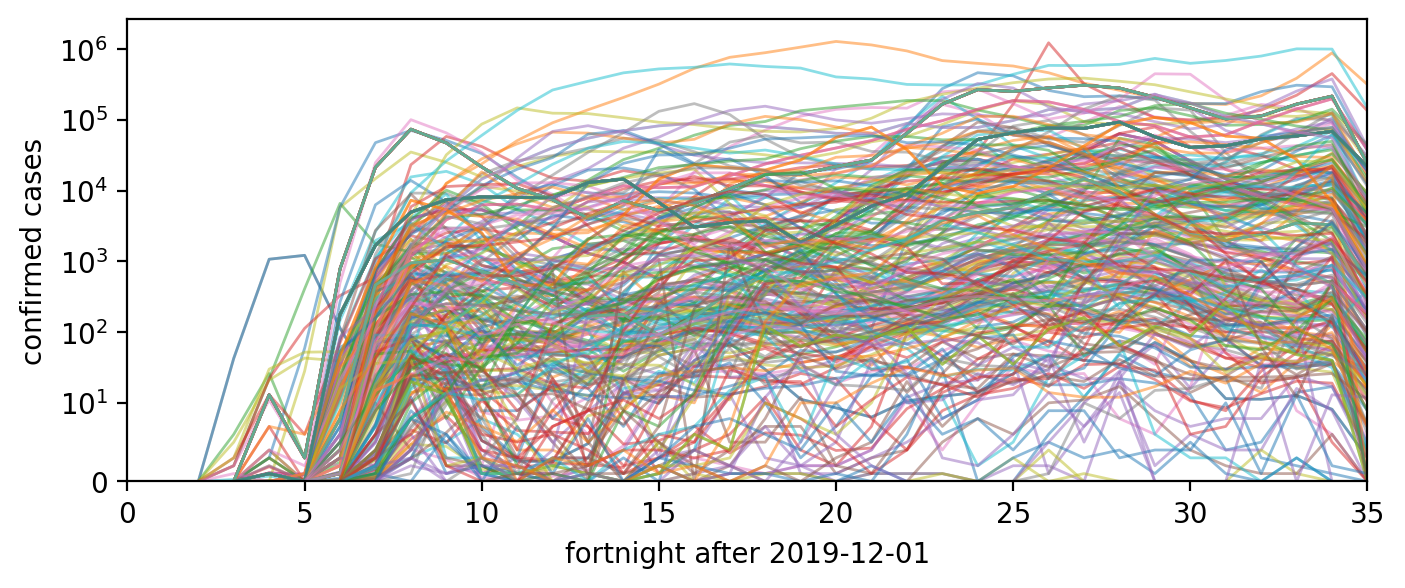

In [35]:
plt.figure(figsize=(8, 3))
plt.plot(weekly_cases, lw=1, alpha=0.5)
plt.yscale("symlog", linthresh=10)
plt.ylim(0, None)
plt.xlim(0, len(weekly_cases) - 1)
plt.xlabel("fortnight after 2019-12-01")
plt.ylabel("confirmed cases");

In [36]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

54 4 229


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [38]:
fits = torch.load("results/mutrans.pt", map_location="cpu")
svi_fit = list(fits.values())[0]
mcmc_fit = list(fits.values())[1]
for key in fits:
    print(key)
print("SVI:", svi_fit.keys())
print("MCMC:", mcmc_fit.keys())
print(mcmc_fit["diagnostics"].keys())
print(mcmc_fit["diagnostics"]["rate_coef"].keys())
print(mcmc_fit["median"].keys())
print(len(svi_fit["mutations"]))

('mvn_dependent', 10001, 0.01, 0.1, ())
('mcmc', 1000, 1000, 10, ())
('map', 1001, 0.05, 1.0, ())
('normal', 2001, 0.05, 0.1, ())
('mvn', 10001, 0.01, 0.1, ())
('mvn_dependent', 10001, 0.01, 0.1, (('exclude', (('location', '^Europe / United Kingdom'),)),))
('mvn_dependent', 10001, 0.01, 0.1, (('exclude', (('location', '^North America / USA'),)),))
('mvn_dependent', 10001, 0.01, 0.1, (('include', (('location', '^Europe / United Kingdom'),)),))
('mvn_dependent', 10001, 0.01, 0.1, (('include', (('location', '^North America / USA'),)),))
('mvn_dependent', 10001, 0.01, 0.1, (('include', (('virus_name', '^hCoV-19/USA/..-CDC-'),)),))
('mvn_dependent', 10001, 0.01, 0.1, (('include', (('virus_name', '^hCoV-19/USA/..-CDC-2-'),)),))
SVI: dict_keys(['median', 'mean', 'cov', 'var', 'std', 'losses', 'params', 'walltime', 'args', 'mutations'])
MCMC: dict_keys(['losses', 'diagnostics', 'samples', 'walltime', 'args', 'median', 'mean', 'std', 'mutations'])
dict_keys(['rate_coef', 'divergences', 'accepta

## Assess model fitness

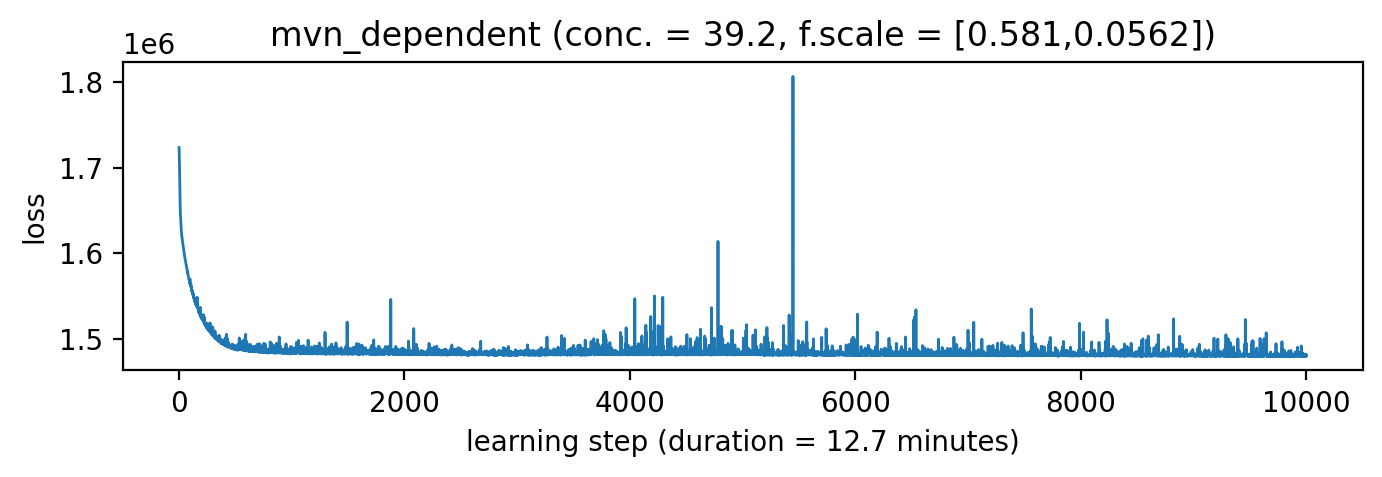

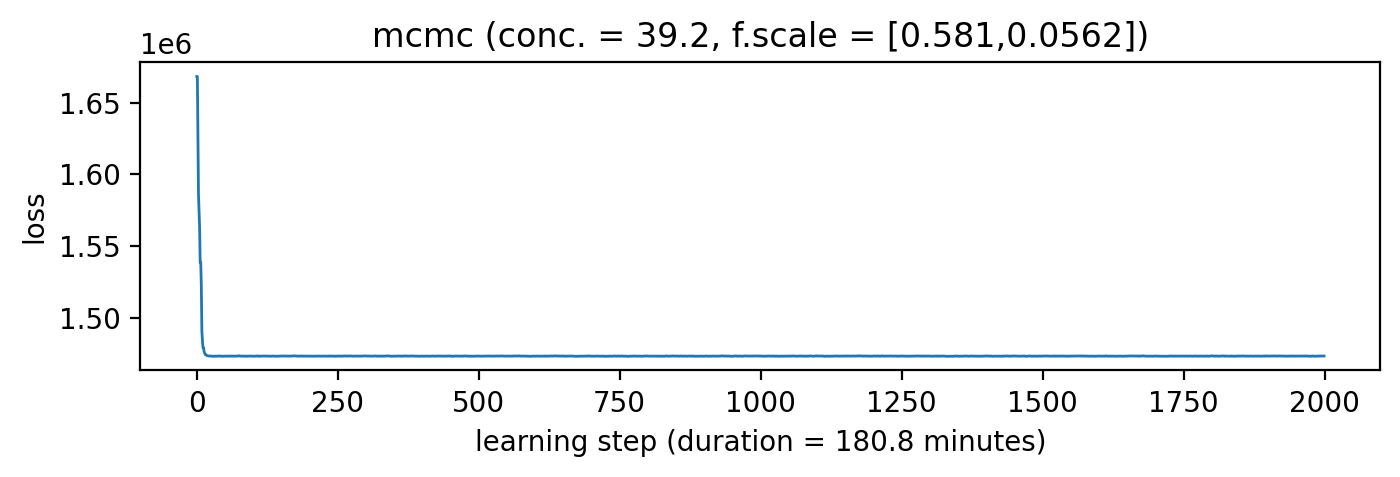

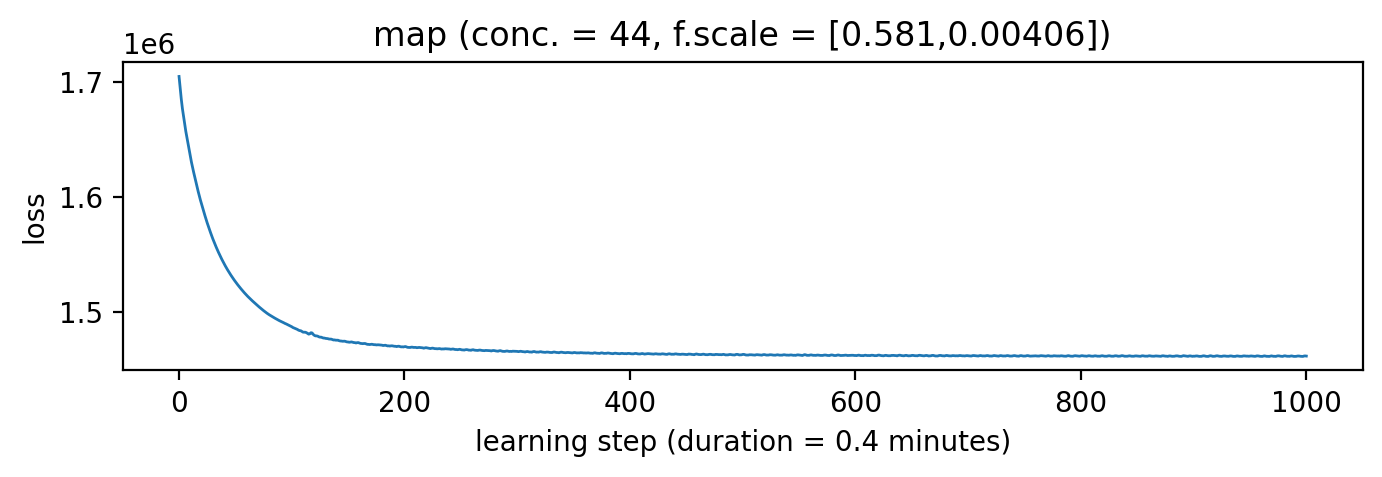

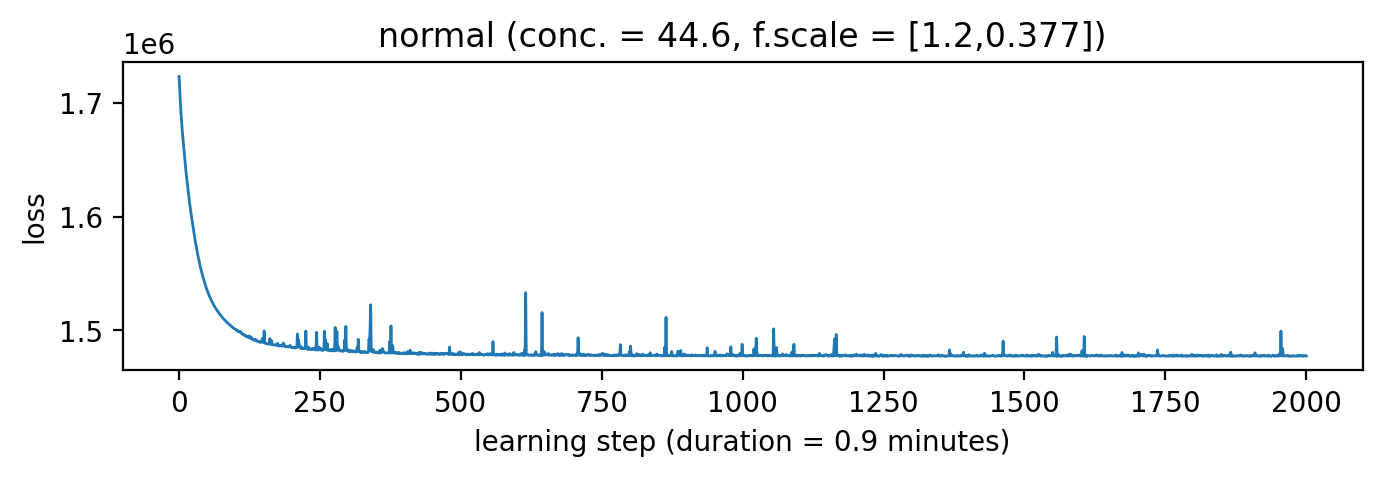

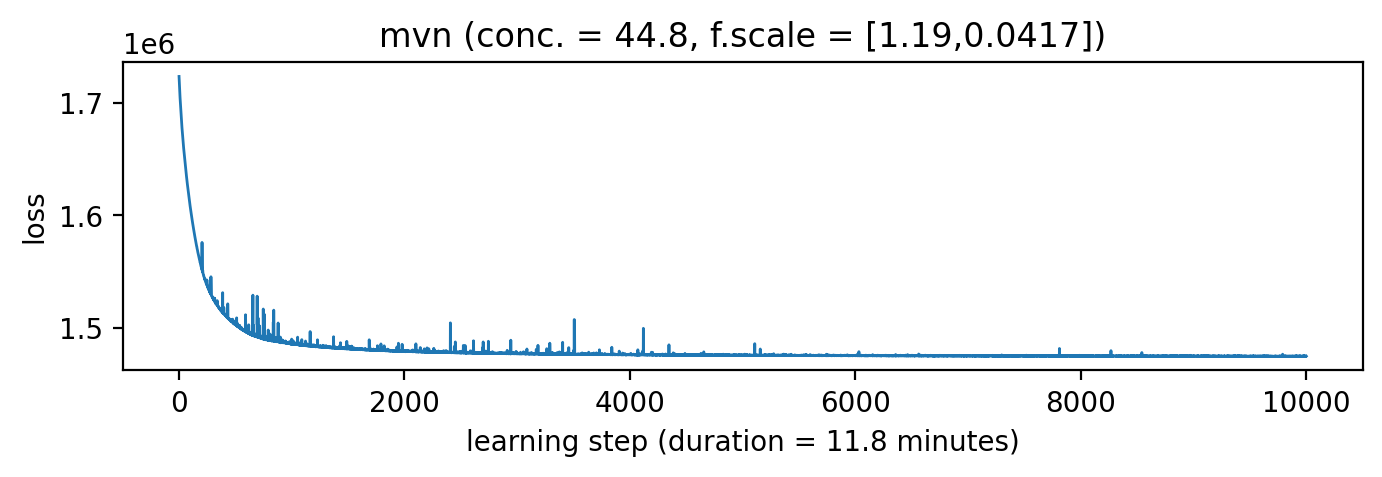

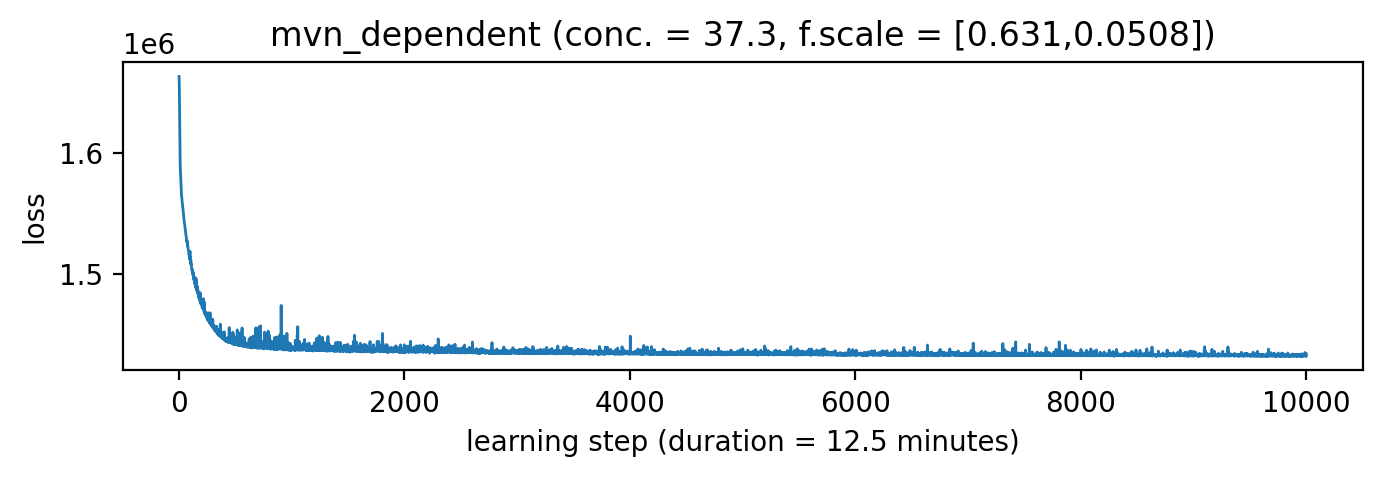

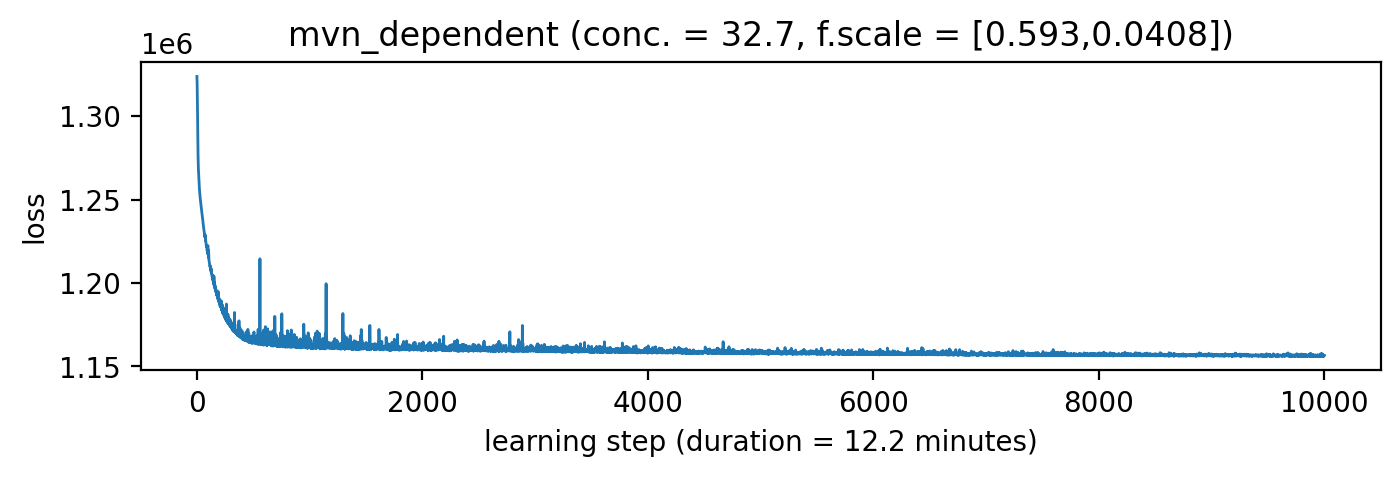

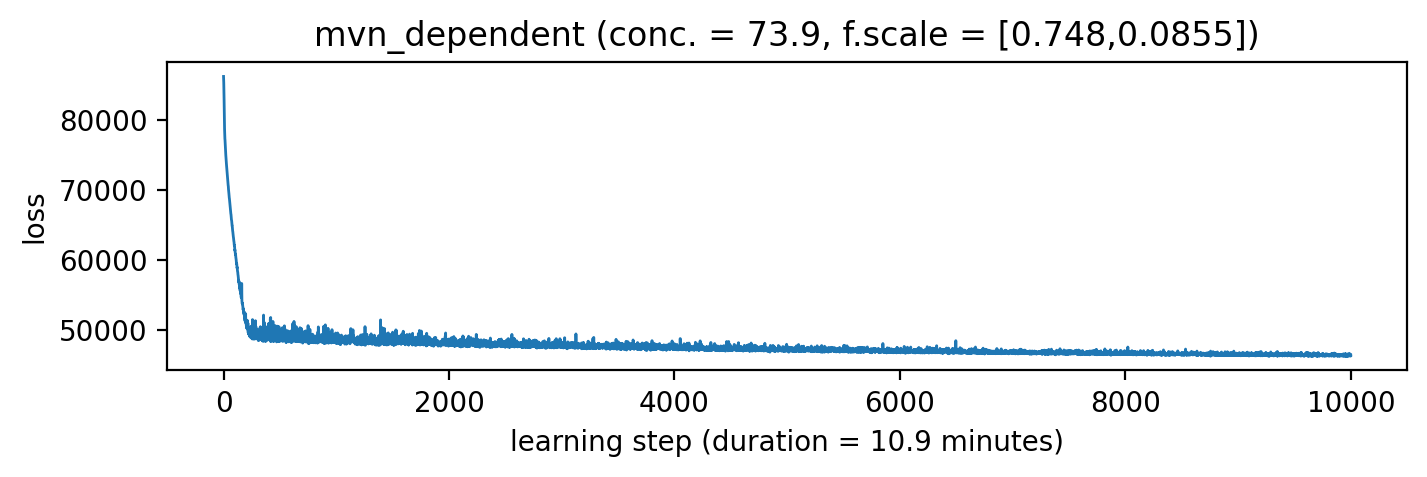

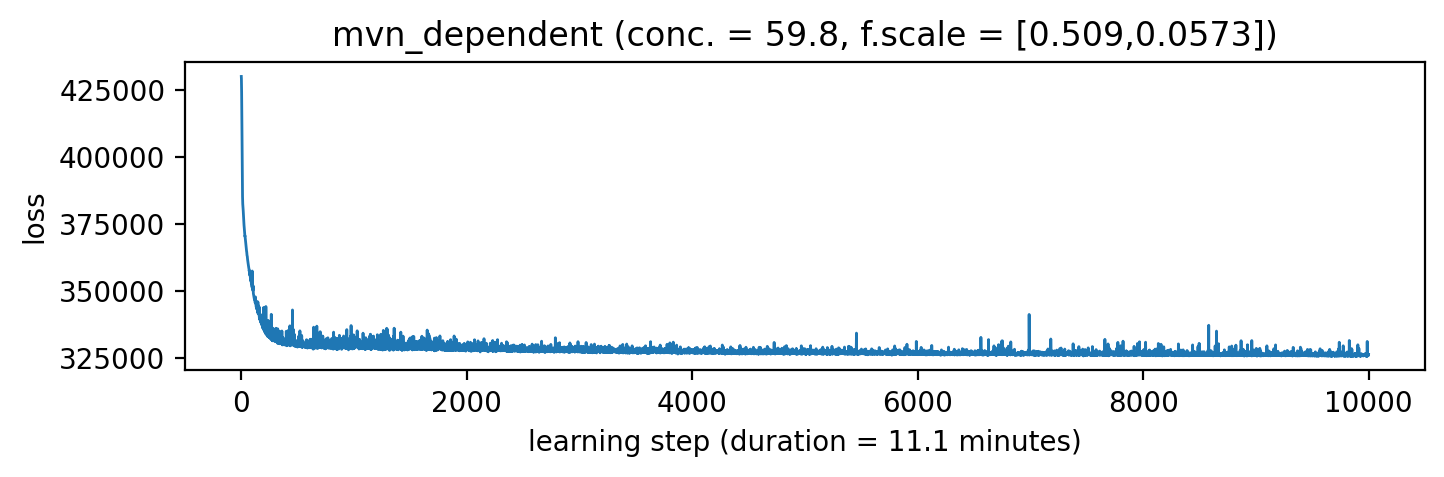

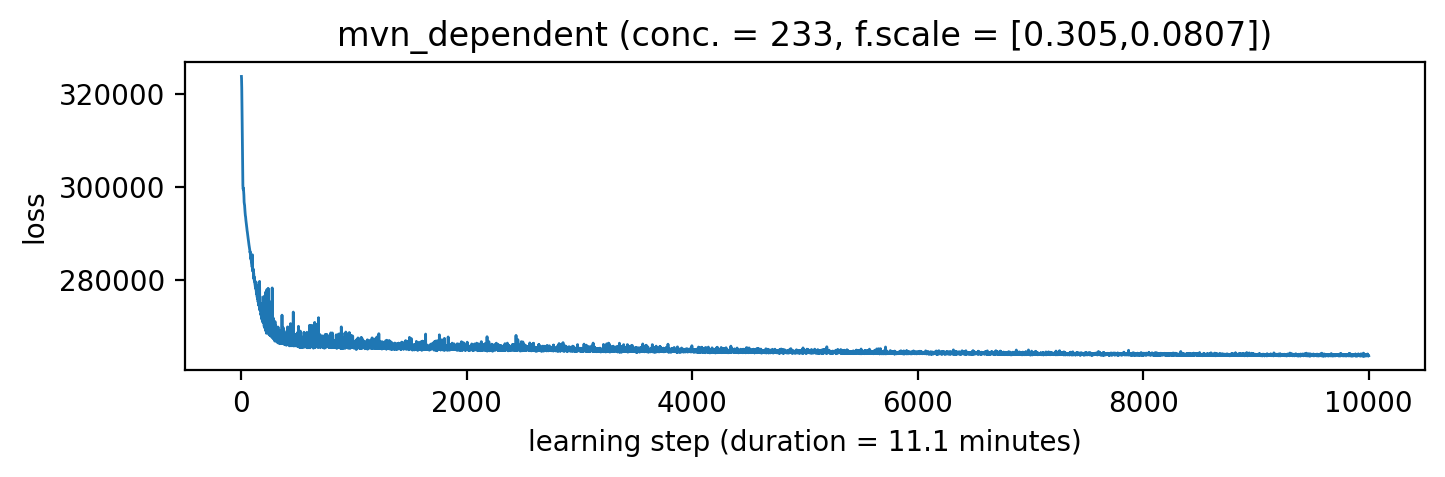

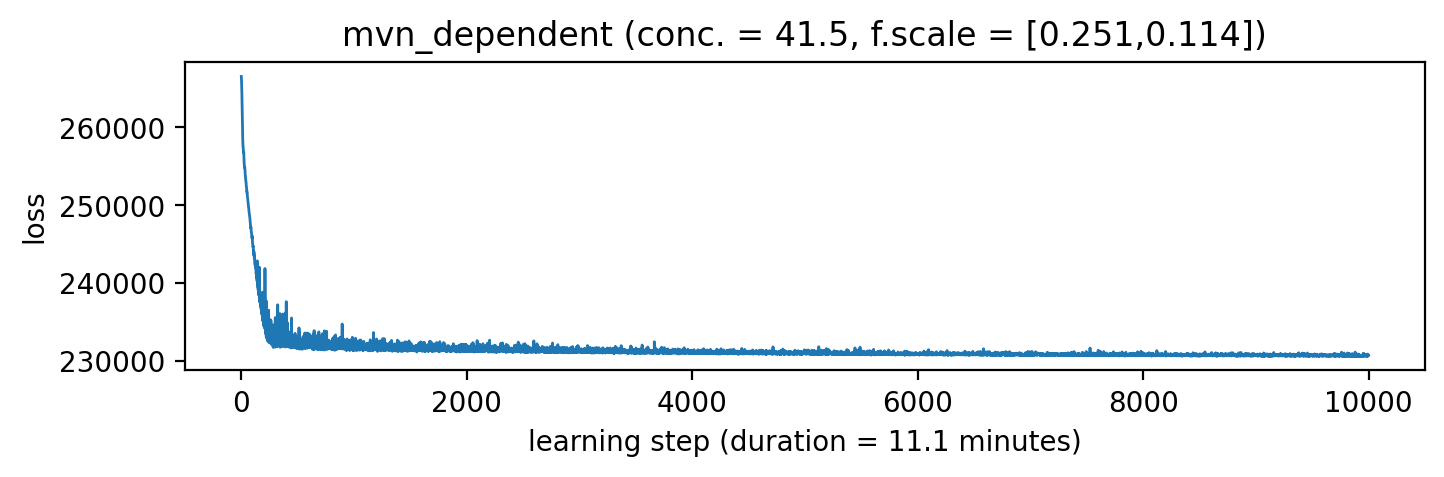

In [39]:
for key, value in fits.items():
    median = value["median"]
    plt.figure(figsize=(8, 2))
    plt.plot(value["losses"], lw=1)
    plt.xlabel("learning step (duration = {:0.1f} minutes)".format(value["walltime"]/60))
    plt.ylabel("loss")
    plt.title("{} (conc. = {:0.3g}, f.scale = {})".format(
        key[0],
        median["concentration"].item(),
        "[{}]".format(",".join(f"{f:0.3g}" for f in median["feature_scale"].tolist()))
    ));

ERROR n_eff is NAN


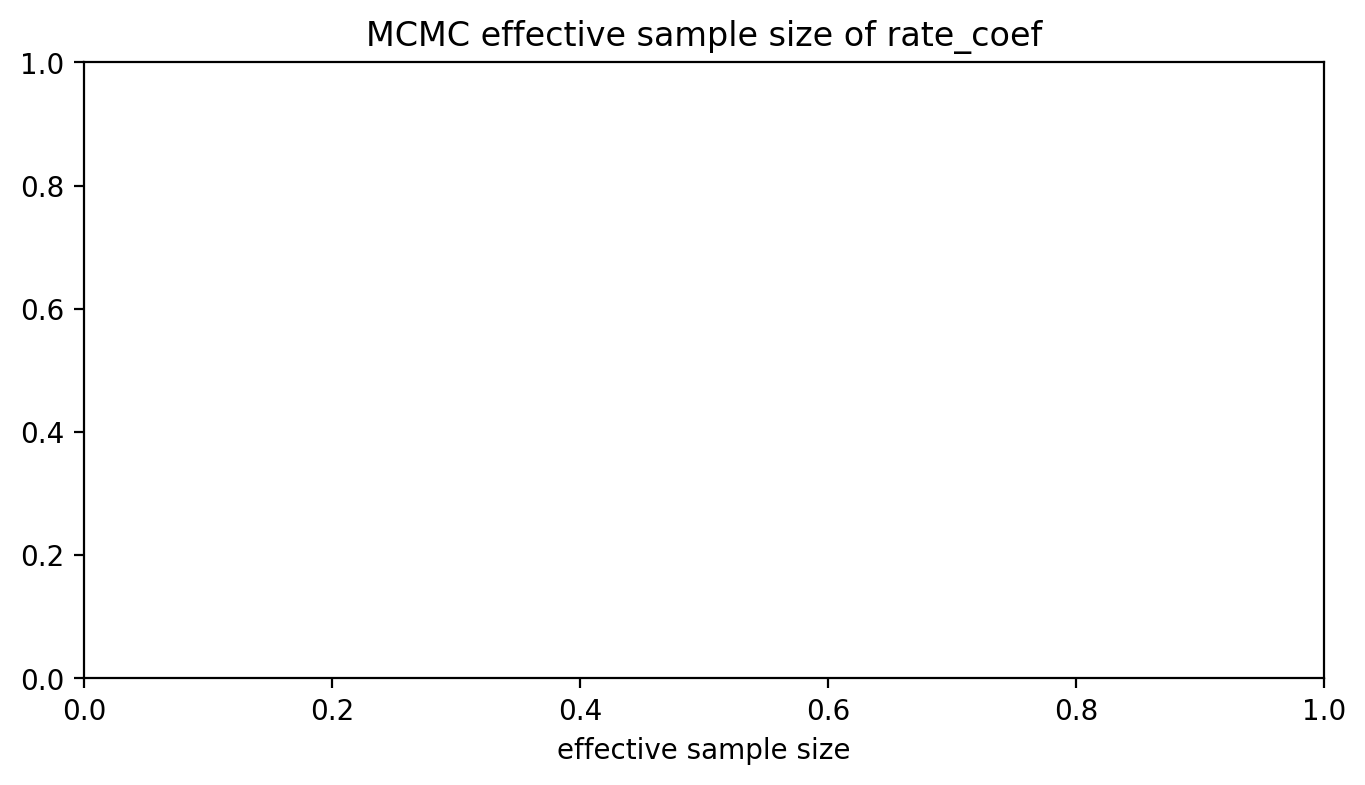

In [40]:
mcmc_fits = []
for key, fit in fits.items():
    if key[0] != "mcmc":
        continue
    max_tree_depth = key[3]
    n_eff = fit["diagnostics"]["rate_coef"]["n_eff"]
    mcmc_fits.append((max_tree_depth, n_eff))
fig, axes = plt.subplots(len(mcmc_fits), 1, sharex=True, figsize=(8, 3 + len(mcmc_fits)))
if len(mcmc_fits) == 1:
    axes = [axes]
for (max_tree_depth, n_eff), ax in zip(mcmc_fits, axes):
    if torch.isnan(n_eff).any():
        print("ERROR n_eff is NAN")
        continue
    base = 2 ** 0.25
    bins = [base ** i for i in range(int(n_eff.log().min() / math.log(base)),
                                     int(n_eff.log().max() / math.log(base)) + 2)]
    ax.hist(n_eff.numpy(), bins=bins)
    ax.set_xscale("log")
    ax.set_ylabel(f"mtd = {max_tree_depth}")
axes[0].set_title("MCMC effective sample size of rate_coef")
axes[-1].set_xlabel("effective sample size")
plt.subplots_adjust(hspace=0);

In [41]:
if torch.isnan(n_eff).any():
    print("ERROR n_eff is NAN")
else:
    sigma = mcmc_fit["mean"] / mcmc_fit["std"]
    plt.scatter(sigma.numpy(), n_eff.numpy(), 20, lw=0, alpha=0.3)
    plt.ylabel("effective sample size")
    plt.xlabel("statistical significance = |μ|/σ")
    plt.xscale("symlog", linthresh=2)
    plt.yscale("log")
    plt.title("Does N_eff depend on the significance metric?")
    plt.tight_layout();

ERROR n_eff is NAN


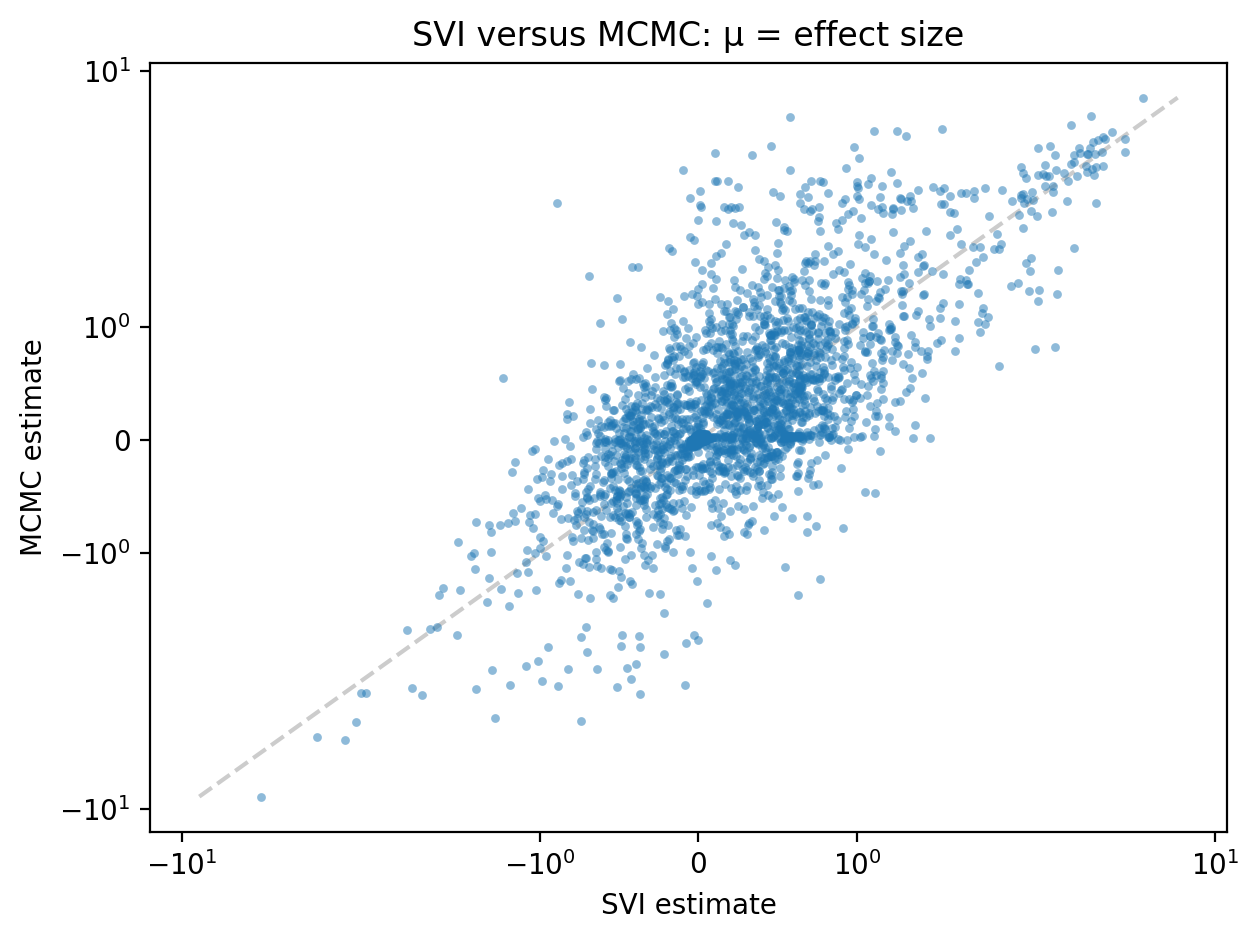

In [42]:
plt.scatter(
    svi_fit["mean"].numpy(),
    mcmc_fit["mean"].numpy(),
    10, lw=0, alpha=0.5
)
x0 = min(svi_fit["mean"].min().item(), mcmc_fit["mean"].min().item())
x1 = max(svi_fit["mean"].max().item(), mcmc_fit["mean"].max().item())
plt.plot([x0, x1], [x0, x1], 'k--', alpha=0.2, zorder=-100)
plt.xscale("symlog")
plt.yscale("symlog")
plt.title("SVI versus MCMC: μ = effect size")
plt.xlabel("SVI estimate")
plt.ylabel("MCMC estimate")
plt.tight_layout()

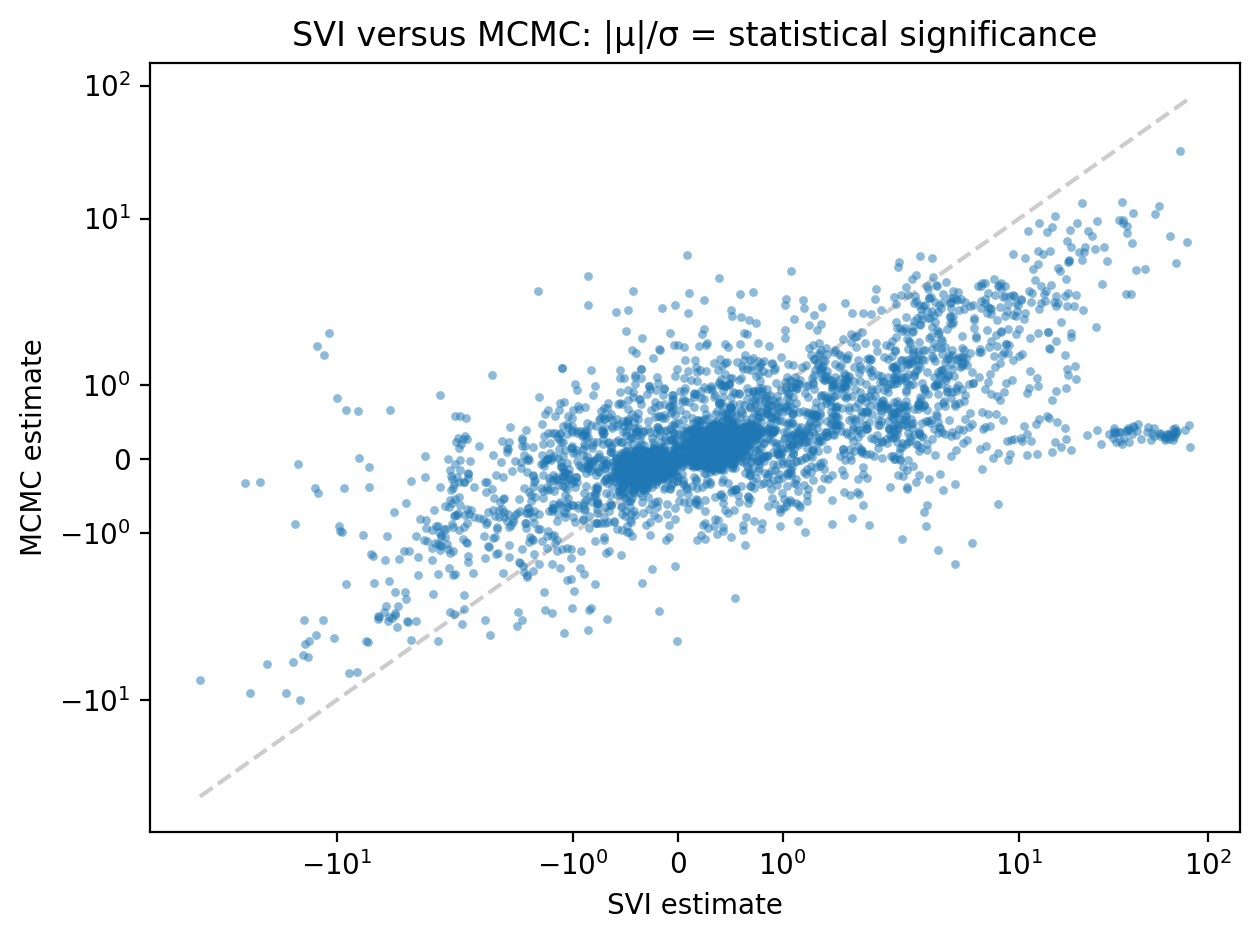

In [43]:
svi_sigma = svi_fit["mean"] / svi_fit["std"]
mcmc_sigma = mcmc_fit["mean"] / mcmc_fit["std"]
plt.scatter(svi_sigma.numpy(), mcmc_sigma.numpy(), 10, lw=0, alpha=0.5)
x0 = min(svi_sigma.min().item(), mcmc_sigma.min().item())
x1 = max(svi_sigma.max().item(), mcmc_sigma.max().item())
plt.plot([x0, x1], [x0, x1], 'k--', alpha=0.2, zorder=-100)
plt.xscale("symlog")
plt.yscale("symlog")
plt.title("SVI versus MCMC: |μ|/σ = statistical significance")
plt.xlabel("SVI estimate")
plt.ylabel("MCMC estimate")
plt.tight_layout()

## Interpreting results

In [44]:
def plot_coefficients(name, rate_coef):
    xs, idx = rate_coef.sort(0)
    assert len(idx) == len(mutations)
    plt.figure(figsize=(6, 6))
    plt.title(f"{name} regression coefficients (mutations)")
    plt.plot(xs, 'k.', lw=0, markersize=1, zorder=10)
    plt.axhline(0, color='black', lw=0.5, linestyle='--', alpha=0.5)
    plt.xlabel(f"rank among {len(xs)} mutations")
    plt.ylabel("increased transmissibility")

    I = len(idx)
    y0 = float(xs.min())
    y1 = float(xs.max())
    N = 50
    for i in range(N):
        x = -I / 8
        y = y0 + (y1 - y0) * i / (N - 1)
        plt.plot([i, x], [xs[i], y], color='blue', lw=0.3)
        plt.text(x, y, mutations[int(idx[i])] + " ", fontsize=5, color='blue',
                 verticalalignment="center", horizontalalignment="right")
    for i in range(I - N, I):
        x = I + I / 8
        y = y1 + (y0 - y1) * (I - i - 1) / (N - 1)
        plt.plot([i, x], [xs[i], y], color='red', lw=0.3)
        plt.text(x, y, " " + mutations[int(idx[i])], fontsize=5, color='red',
                 verticalalignment="center", horizontalalignment="left")
    plt.ylim(y0 - (y1 - y0) / 40, y1 + (y1 - y0) / 40)
    plt.xlim(-0.35 * I, 1.35 * I)
    plt.xticks(())

plot_coefficients("SVI", svi_fit["median"]["rate_coef"])
plot_coefficients("MCMC", mcmc_fit["median"]["rate_coef"])

AssertionError: 

In [ ]:
%debug

> <ipython-input-44-4efb221ed3f8>(3)plot_coefficients()
      1 def plot_coefficients(name, rate_coef):
      2     xs, idx = rate_coef.sort(0)
----> 3     assert len(idx) == len(mutations)
      4     plt.figure(figsize=(6, 6))
      5     plt.title(f"{name} regression coefficients (mutations)")

ipdb> p len(mutations)
5956
ipdb> p rate_coef.shape
torch.Size([5946])


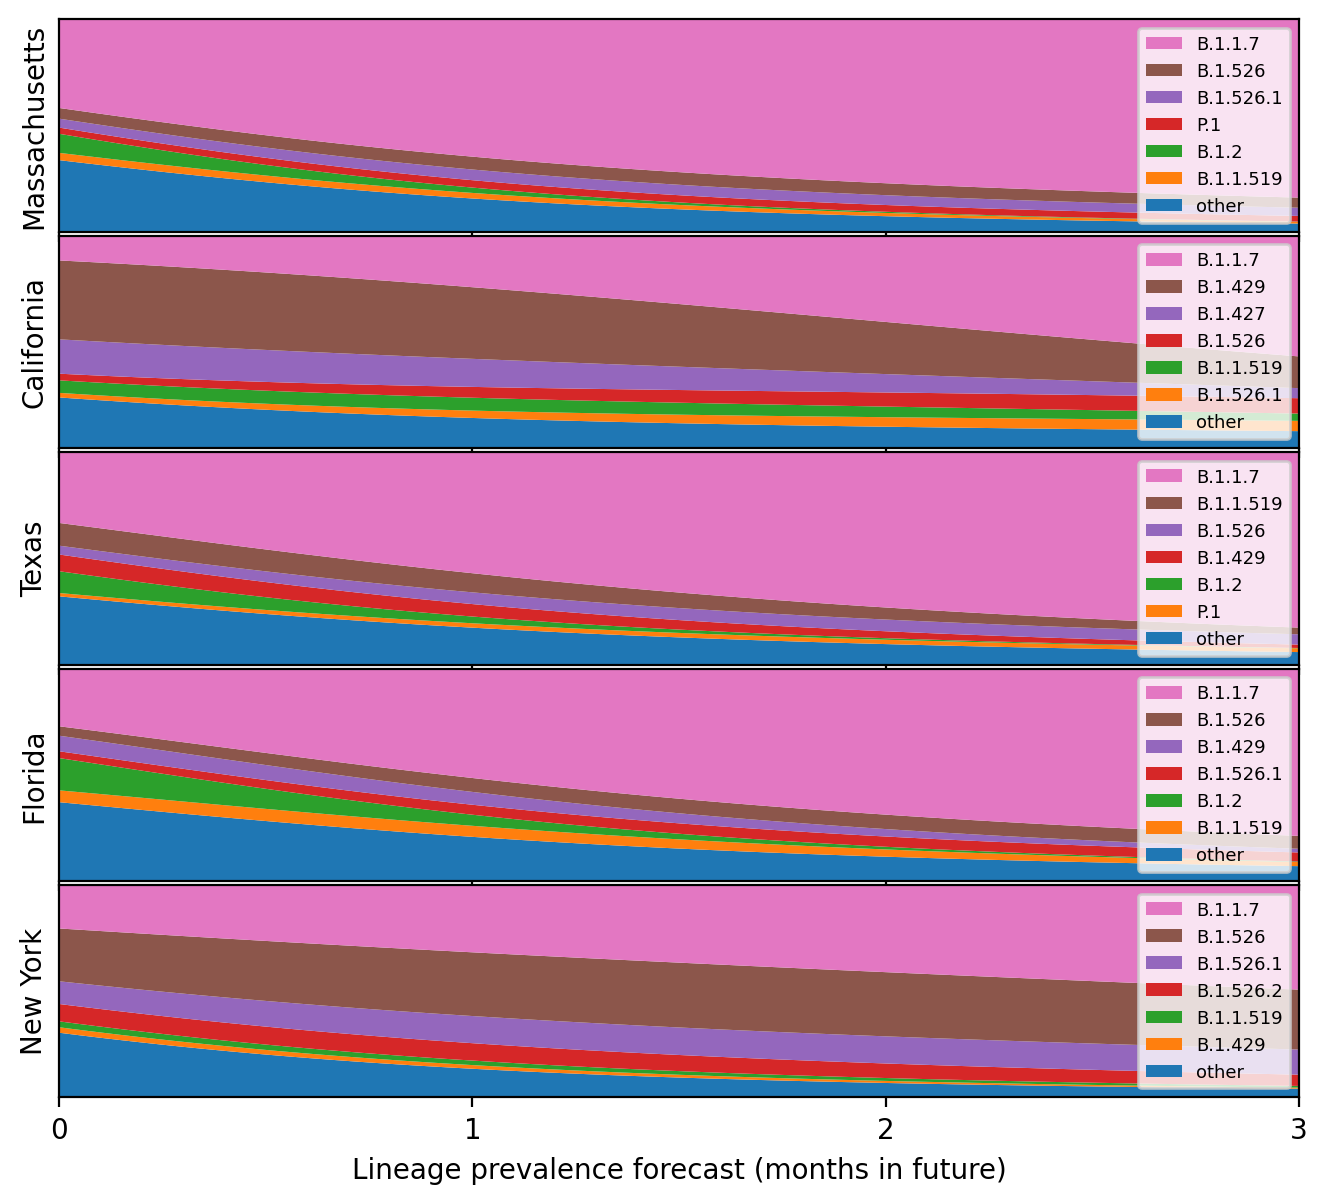

In [23]:
def plot_decomposition(median, queries, num_parts=7, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.2 * len(queries)), sharex=True)
    for row, (place_query, ax) in enumerate(zip(queries, axes)):
        names = [name for name, i in location_id.items() if place_query in name]
        assert len(names) == 1, place_query
        id_ = location_id[names[0]]
        rate = median["rate"]
        # FIXME this ignores region population when aggregating:
        init = median["init"][id_]
        assert init.shape == rate.shape
        time = torch.linspace(0, months_ahead / 12.0, 100)
        local_time = time + dataset["local_time"][-1, id_]
        portion = (init + rate * local_time[:, None]).softmax(-1)

        # Aggregate into top + others.
        best = portion.sum(0).sort(0, descending=True).indices
        parts = {"other": None}
        for i in range(num_parts - 1):
            i = best[num_parts - i - 2].item()
            parts[lineage_id_inv[i]] = portion[:, i].clone()
            portion[:, i] = 0
        parts["other"] = portion.sum(-1)
        months = time * 12

        ax.stackplot(months, *parts.values(), labels=tuple(parts))
        ax.set_xlim(months.min(), months.max())
        ax.set_xticks((0, 1, 2, 3))
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(names[0].split("/")[-1].strip() if len(names) == 1 else place_query)
        if row == len(axes) - 1:
            ax.set_xlabel("Lineage prevalence forecast (months in future)")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1], loc="lower right", prop={"size": 6.5})
    plt.subplots_adjust(hspace=0.02);

plot_decomposition(mcmc_fit["median"],
                   ["Mass", "Calif", "Texas", "Florida", "New York"])

In [24]:
def plot_baby_volcano(mean, std, linthresh=5):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    mask = (xs > 0) & (ys > p95)

    plt.figure(figsize=(4, 4), dpi=300)
    plt.title(f"Δ transmissibility of {len(mutations)} mutations")
    plt.scatter(xs[~mask], ys[~mask], 5, color='#aaaaaa', lw=0)
    plt.scatter(xs[mask], ys[mask], 5, color='black', lw=0)
    plt.xlabel("effect size")
    plt.ylabel("statistical significance")
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    # yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100] if y < y1]
    # plt.yticks(yticks, list(map(str, yticks)))
    plt.yticks(())
    plt.xticks((-10, -5, 0, 5, 10))
    for spine in plt.gca().spines.values():
        spine.set_linewidth(0.5)
    plt.axhline(p95, color='k', linestyle='--', alpha=0.3, zorder=-10)
    plt.text(0.8 * x0 + 0.2 * x1, p95 * 0.85, "95% probabililty\nof correct sign",
             fontsize=10, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
    plt.tight_layout()

plot_baby_volcano(mcmc_fit["mean"], mcmc_fit["std"])

AssertionError: 

In [25]:
def plot_volcano(mean, std, filenames=(), linthresh=10, top_k=60):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("μ = effect size")
    plt.ylabel("|μ|/σ = statistical significance")
    lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    plt.text(0.2 * x0 + 0.8 * x1, p95 * 0.95, "95% probabililty\nof correct sign",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
        name = mutations[int(idx_neg[i])]
        plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(mcmc_fit["mean"], mcmc_fit["std"], linthresh=5,
             filenames=["paper/volcano.png", "paper/volcano.pdf"])

AssertionError: 

In [26]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=50, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots scaled by effect size)")
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 8 * mean[mask].numpy(),
                    color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items()}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.8 + y1 * 0.2
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("statistical significance = |μ|/σ")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(mcmc_fit["mean"], mcmc_fit["std"],
               filenames=["paper/manhattan.png", "paper/manhattan.pdf"])

AssertionError: 

In [27]:
def plot_upper_east_side(mean, std, top_k=120, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id["N"]) & (mean > 0)

    plt.figure(figsize=(12, 4))
    plt.title(f"Increased transmissibility of mutations within N gene"
              " (dots scaled by effect size)")
    plt.scatter(position[mask].numpy(), sigma[mask].numpy(), 8 * mean[mask].numpy(),
                color="darkblue", alpha=0.5, lw=0)
    special = []  # Many hits, plot with lines
    z0 = 28800
    z1 = 29000
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene != "N":
            continue
        if z0 < x < z1:
            special.append((y, x, name))
        else:
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
    special.sort(reverse=True)
    lb = min(y for (y, _, _) in special)
    ub = max(y for (y, _, _) in special)
    lb, ub = lb * 0.5, ub * 0.5 + y1 * 0.5
    for i, (y, x, name) in enumerate(special):
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special) - 0.99)))
        x_label = z1
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    start, end = GENE_TO_POSITION["N"]
    plt.xlim(start, end)
    xticks = [start]
    while xticks[-1] + 150 < end:
        xticks.append(xticks[-1] + 150)
    labels = [str((x - start) // 3) for x in xticks]
    plt.xticks(xticks, labels)
    plt.xlabel("amino acid position within N gene")
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("statistical significance = |μ|/σ")
    for f in filenames:
        plt.savefig(f)

plot_upper_east_side(mcmc_fit["mean"], mcmc_fit["std"],
                     filenames=["paper/upper_east_side.png", "paper/upper_east_side.pdf"])

AssertionError: 

In [ ]:
def plot_prevalence(filenames=()):
    rate = mcmc_fit["median"]["rate"]
    rate = rate - rate[lineage_id["A"]]
    R = (rate * 5.5 / 365.25).exp()
    init = mcmc_fit["median"]["init"] + dataset["local_time"][-2, :, None] * rate
    init = init - init.logsumexp(-1, True)
    cases = torch.einsum("ps,p->s", init.exp(), weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        if cases[i] <= 1.1:
            continue
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("log")
    #plt.xscale("log")
    plt.ylim(1, None)
    plt.xlim(0.9, None)
    xticks = (0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5)
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_A$")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)
    
plot_prevalence(["paper/strain_prevalence.png",
                 "paper/strain_prevalence.pdf"])

## Extracting a table of top mutations and their stories

In [ ]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [ ]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [ ]:
def write_mutation_table(mean, std, filename, top_k=None):
    sigma = mean / std.clamp(min=1e-8)
    R_RA = (mean * 5.5 / 365.25).exp()  # 5.5 is estimated generation time.
    lineage_counts = weekly_strains.sum((0, 1))
    if filename.endswith(".md"):
        with open(filename, "wt") as f:
            f.write("This file was automatically generated by mutrans.ipynb\n")
            f.write("\n")
            f.write("| mutation | mean/stddev | mean | R / R_A | emerged in lineages |\n")
            f.write("| -------- | ----------- | ---- | ------- | ------------------- |\n")
            for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
                emerged = find_emergences(i)
                f.write("| {} | {:0.3g} | {:0.3g} | {:0.3g} | {} |\n".format(
                    mutations[i], sigma[i], mean[i], R_RA[i], ", ".join(emerged)
                ))
    elif filename.endswith(".tsv"):
        with open(filename, "wt") as f:
            f.write("mutation\tmean/stddev\tmean\tR / R_A\temerged in lineages\n")
            for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
                emerged = find_emergences(i)
                f.write("{}\t{:0.6g}\t{:0.6g}\t{:0.6g}\t{}\n".format(
                    mutations[i], sigma[i], mean[i], R_RA[i], ", ".join(emerged)
                ))
    else:
        raise ValueError(filename)

write_mutation_table(mcmc_fit["mean"], mcmc_fit["std"], "paper/mutations.tsv")
write_mutation_table(mcmc_fit["mean"], mcmc_fit["std"], "paper/top_mutations.md", top_k=100)
pd.read_csv("paper/mutations.tsv", sep="\t")

In [ ]:
def write_strain_table(mean, filename, top_k=None):
    rate = mean.type_as(features) @ features.T
    R = (rate * 5.5 / 365.25).exp()  # 5.5 is estimated generation time.
    R_RA = R / R[lineage_id["A"]]
    logits = mcmc_fit["median"]["init"] + dataset["local_time"][..., None] * rate
    probs = (logits - logits.logsumexp(-1, True)).exp()
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    ranked = rate.sort(0, descending=True).indices[:top_k].tolist()
    if filename.endswith(".md"):
        with open(filename, "wt") as f:
            f.write("This file was automatically generated by mutrans.ipynb\n")
            f.write("\n")
            f.write("| strain | R / R_A | confirmed cases / day | confirmed cases total |\n")
            f.write("| ------ | ------- | --------------------- | --------------------- |\n")
            for i in ranked:
                f.write("| {} | {:.3g} | {:.1f} | {:.1f}\n".format(
                    lineage_id_inv[i], R_RA[i], cases_per_day[i], cases_total[i]
                ))
    elif filename.endswith(".tsv"):
        with open(filename, "wt") as f:
            f.write("strain\tR / R_A\tconfirmed cases / day\tconfirmed cases total\n")
            for i in ranked:
                f.write("{}\t{:.6g}\t{:0.6g}\t{:.6g}\n".format(
                    lineage_id_inv[i], R_RA[i], cases_per_day[i], cases_total[i]
                ))
    else:
        raise ValueError(filename)

write_strain_table(mcmc_fit["mean"], "paper/strains.tsv")
write_strain_table(mcmc_fit["mean"], "paper/top_strains.md", top_k=100)
pd.read_csv("paper/strains.tsv", sep="\t")

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

In [ ]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

In [ ]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

In [ ]:
def correlation(x, y):
    x = x / x.std()
    y = y / y.std()
    return (x * y).mean()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = mcmc_fit["mean"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
axes[0].set_ylabel("Δ transmissibility")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {correlation(x, y):0.3g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing transmissibility against theses deep scanning results.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model():
    trans_data = mcmc_fit["mean"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("transmissibility = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model()

## Fit on subsets of data

In [ ]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)

In [ ]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))

In [ ]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1]}
for key in holdout_fits:
    print(key[-1])

In [ ]:
aliases = [
    "excluding the UK",
    "excluding the USA",
    "only the UK",
    "only the USA",
    "only CDC data",
    "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, holdout_fits.values()))

In [ ]:
def plot_mean_agreements(fit1, holdouts, filenames=()):
    x0 = min(f["mean"].min().item() for f in [fit1] + list(holdouts.values()))
    x1 = max(f["mean"].max().item() for f in [fit1] + list(holdouts.values()))
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    fig, axes = plt.subplots(1, len(holdouts), figsize=(11, 2), sharey=True)
    fig.suptitle("Agreement of mean estimates between full versus subsets of data")
    for ax, (name, fit2) in zip(axes, holdouts.items()):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit in (fit1, fit2):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(fit["mean"][idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 15, alpha=0.5, lw=0)
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_mean_agreements(svi_fit, holdout_fits,
                     filenames=["paper/agreement.png", "paper/agreement.pdf"])